# Implementing the guideline in Python

This notebook gives an example of how to implement the guideline in Python using the `h5py` package. 

The owners of a building (shear-frame with four floors) have received complaints from residents that there are excessive vibrations in the building which causes discomfort. A project is established to determine the cause of these vibrations and suggest a solution to the problem. At this stage, the main suspect for the excessive vibrations is a gym located at the first floor of the building. A measurement setup, with two accelerometers and two different trials is used. In the first trial, people are jumping around on the first floor to simulate activity in the gym. In the second, trial only ambient excitation is used. An illustration of the project is given below.

![shear-frame-example](shear-frame.png)

Assume that the measurements have been performed, and that the data from the two trials are available. We generate `y_trial1` and `y_trial2` below, but typically these would be loaded from the data files produced by your measurement system. 

In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

In [2]:
fs = 100 # Hz
T  = 180 # s

t = np.arange(0., T, 1./fs) # Time vector, assume same for both trials
y_trial1 = np.random.normal(size=(2, t.size)) # Measurements from trial 1
y_trial2 = np.random.normal(size=(2, t.size)) # Measurements from trial 2

Now, let us start creating a HDF5 file:

In [3]:
h5f = h5py.File("shear-frame.h5", "w")

and remember, a HDF5 file is also a HDF5 group.

In [4]:
print("HDF5 file is also a group?", isinstance(h5f, h5py.Group))

HDF5 file is also a group? True


Since this is the only measurement project that is going into this file, we add the project metadata to the attributes of the root group:

In [5]:
h5f.attrs["name"] = "IMGIP - Implementation of metadata guideline in python."
h5f.attrs["contact"] = "Gunnstein T. Frøseth <mailto:gunnstein.t.froseth@ntnu.no>"
h5f.attrs["description"] = "This project investigates if the comfort criteria wrt. accelerations " \
                           "in a building (shear frame) with three floors are met if a gym is opened " \
                           "on the second floor. " \
                           "Two trials are performed, one with people jumping around on first floor " \
                           "and another where there is only ambient excitation."
h5f.attrs["location"] = "Shear frame building, 30309, Gotham City."
h5f.attrs["coordinate system"] = "Cartesian coordinate system with origin in base of left column, " \
                                 "x-axis positive towards right column, z-axis positive upwards and " \
                                 "y-axis defined by a right hand system."

Next, we can add the groups for trial 1 and trial 2 under the root, in `h5py` this can be done with the `require_group` method on the root object. We also add the associated metadata to these groups:

In [6]:
trial_1 = h5f.require_group("trial 1")
trial_1.attrs["name"] = "Trial 1"
trial_1.attrs["description"] = "Two persons excite the structure by jumping around on second floor. " \
                               "The trial was started 2021-02-24Z12:01:14. The ambient outside temperature " \
                               "was 8 centigrades and there was very litte wind."

trial_2 = h5f.require_group("trial 2")
trial_2.attrs["name"] = "Trial 2"
trial_2.attrs["description"] = "Building is empty, only ambient excitation. " \
                               "The trial was started 2021-02-24Z12:01:14. The ambient outside temperature " \
                               "was 8 centigrades and there was very litte wind."

Finally, we are ready to the data to the file. We start with trial 1:

In [7]:
trial_1.create_dataset("time", data=t)
dataset_A1 = trial_1.create_dataset("A1", data=y_trial1[0])
dataset_A2 = trial_1.create_dataset("A2", data=y_trial1[1])

we must also remember to add the metadata as attributes of the dataset. We can achieve this by the `attrs` property of the dataset object exactly like for the groups. 

In [8]:
dataset_A1.attrs["name"] = "A1"
dataset_A1.attrs["coordinate"] = np.array([0., 0., 3.])

since we also have the exact same sensors and metadata for trial 2, we will add the metadata to the data set with a loop:

In [9]:
sensor_metadata ={
    "A1":{
        "name": "A1",
        "coordinate": np.array([0., 0., 3.]),
        "orientation": np.array([1., 0. ,0.]),
        "description": "ACME 668 single axis accelerometer, SN:10012, mounted on column with magnet.",
        "unit": "Volt (V)",
        "conversion": "1002 mV/g",
    },
    "A2":{
        "name": "A2",
        "coordinate": np.array([8., 0., 9.]),
        "orientation": np.array([-1., 0. ,0.]),
        "description": "ACME 668 single axis accelerometer, SN:10013, mounted on column with magnet.",
        "unit": "Volt (V)",
        "conversion": "1093 mV/g",
    },
}

trial_1["time"].attrs["description"] = "Time vector for the data from accelerometers in the project."

for name, metadata in sensor_metadata.items():
    dataset = trial_1[name]
    for k, v in metadata.items():
        dataset.attrs[k] = v

almost done, but we must add the data and metadata to the second trial:

In [10]:
trial_2.create_dataset("time", data=t)
dataset_A1 = trial_2.create_dataset("A1", data=y_trial2[0])
dataset_A2 = trial_2.create_dataset("A2", data=y_trial2[1])

trial_2["time"].attrs["description"] = "Time vector for the data from accelerometers in the project."

for name, metadata in sensor_metadata.items():
    dataset = trial_1[name]
    for k, v in metadata.items():
        dataset.attrs[k] = v

Finally, we close the HDF5 file and it is ready for further use or archiving.

In [11]:
h5f.close()

# Loading and exploring the data in a HDF5 file

There exists stand alone data explorers for HDF5 files, check out [HDF View](https://www.hdfgroup.org/downloads/hdfview/).

See how to load, inspect and navigate the HDF5 file with `h5py` below:

In [12]:
root = h5py.File("shear-frame.h5", 'r')

In [13]:
root.keys()

<KeysViewHDF5 ['trial 1', 'trial 2']>

In [14]:
trial = root["trial 1"]
trial.keys()

<KeysViewHDF5 ['A1', 'A2', 'time']>

In [15]:
time = trial["time"]
A1 = trial["A1"]

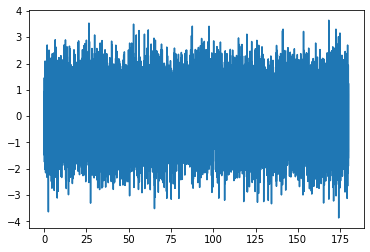

In [16]:
plt.plot(time[:], A1[:])

In [17]:
A1.attrs["description"]

'ACME 668 single axis accelerometer, SN:10012, mounted on column with magnet.'